# Supercharging Decision Making with Bayes
PyData Global 2020

If you are reading the interactive slides from binder, press `space` to move to the next slide.

# Note to those running this locally
Remove the %%capture headers to get the image outputs

In [1]:
import matplotlib.pyplot as plt
from scipy import stats, optimize
import numpy as np
import pandas as pd
np.set_printoptions(precision=2, floatmode="fixed")

In [2]:
def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

Useful links
https://www.markroepke.me/posts/2019/06/05/tips-for-slideshows-in-jupyter.html

Decisions are everywhere, from deciding what to wear given a weather forecast each day to deciding how much inventory to hold in a multi million dollar supply chain. What is certain is that tools in the PyData ecosystem can help you, or your business, make those decisions with more confidence. Its called decision science in this talk we'll cover what it is and how to use it.

## Outline

The talk will be presented in a way that will not require deep knowledge of any of the technical topics, but just an intuition of basic supply, demand, and multiplication. The intent of the talk is to show how the modern computational tools can be used to make more informed decisions and affect change in common business, or even personal life, scenarios

### Introduction
   * Decisions are everywhere
   * Data is now everywhere is well
   * Data informed decisions not so much

### Decisions from summary analysis
   * This is what most businesses do using Excel or Tableau
        *Nothing wrong with this approach. Its quick and reliable and most folks have the skillset
   * While data focused the approach leads itself to human bias
   *  Leaves information on the table
   * Not very reproducible
   * Doesn't scale to many dimensions
   * We can do better

### Loss/Cost/Reward/Utility Functions

    * Taking an idea from Game Theory different versions of the future will have different goodness
    * This lets us determine how much reward we'll get for different actions

### Quantifying Uncertainty

   * Bayesian Methods let us predict the future, not just summarize the past
   * Not just one future though but all futures
   * Particularly well suited to explaining why its predictions are the way they are

### Optimizing over all possible futures

    * Given a distribution of possible futures and a cost function we can optimize to pick an action that will most likely result in the best outcome
    * Open Source code makes it really easy these days!


Technical Summary of talk
I'll be presenting most likely using Jupyter slides. The analysis will cover a little bit of supply chain theory in math form, and then a whole bunch of simulated supply chain theory in using scipy.stats.(random) methods, PyMC3 or Stan for parameter estimation, more scipy for optimization methods, matplotlib for plotting. Of course numpy and pandas will likely be in there somewhere as well.

# Who Am I

* Ravin Kumar
* Data Scientist, Supply Chain Engineer, Bayesian Statistician (Depending on who's asking)
* Twitter and github: canyon289

## Core Contributor for PyMC3 and ArviZ

Insert Picture

# What I used to do: Build supply chain systems stuff like drill ships
![DrillShip](img/DrillShip.png)

# What I used to do: Use python to make rocket ships

![FalconHeavy](img/FalconHeavy.png)

# What I used to do: Use statistics to ship salads
![Sweetgreen](img/Sweetgreen.png)

# What I do now: Data Scientist PyMC Labs


# The power of Bayesian statistics
Math can do a lot of things

* Outcome characterization - This is the distribution of things that happened
* Latent factor analysis - These are the things affect your outcome
* **Decision Making** - Given all the potential outcomes here's the most optimal choice we should make today

# Organizations need to make decisions
Data is optional. The decisions are not
<center><img src="img/BusinessChoices.png" alt="Drawing" style="height: 500px;"/> </center>


# Each decision has an expected outcome
Each choice has a consequence, good or bad

<center><img src="img/BusinessOutcomes.png" alt="Drawing" style="height: 500px;"/> </center>

# Expected outcomes differ from actual outcomes

<center><img src="img/ActualOutcome.png" alt="Drawing" style="height: 500px;"/> </center>

# The trick is picking the choice that leads to the best actual outcome

<center><img src="img/ActualOutcomeRealized.png" alt="Drawing" style="height: 500px;"/> </center>

# Using Bayesian Statistics to pick the best choice (probably)
Bayesian stats does stuff

If we have data, the Bayesian paradigm can help with that decision. Its the only way to do things, but is particularly powerful in situations where other methodologies aren't

# An example: Making decisions as newspaper vendor

## Anisha is starting her new enterprise

* She buys them wholesale for 5 dollars and sells them for 7 dollars. 
* Newspapers only last one day, they become worthless the next day. 
* Each morning she must make a choice of how many to purchase. 
* If she buys too little she loses an opportunity to sell, if she buys too many she wastes money on unsold papers. 

How many should she purchase in the morning to **maximize her profit**?

# How can Anisha get the best outcome using math?
This problem is a"textbook example" Operations Research problem called the newsvendor problem. Also called Single period model


# Profit Calculation

If we know
1. The price Anisha buys the newspapers for
2. The price Anisha sells the newspapers for
3. The demand, or number of papers sold, that day
4. **Anisha's decision**: *The number of newspapers Anisha decides to buy*

We can use of those to directly calculate Anisha's profit.  

*Note*: In the simplest version of this problem we do not account for lost sales, just the transactions that did occur

# Decision 1. Anisha buys 42 newspapers
Let's assume the demand is fixed at 40 newspapers

In [3]:
newspaper_cost = 5
customer_price = 7

anishas_inventory = 42
demand = 40

profit = demand*customer_price - newspaper_cost*anishas_inventory

f"Anisha makes ${profit} in profit"

'Anisha makes $70 in profit'

# Decision 2. Anisha buys 38 newspapers
The demand is 40 newspapers but Anisha can only sell as many as she bought

In [4]:
newspaper_cost = 5
customer_price = 7
anishas_inventory = 38

# Anisha can't sell more news papers than she can buy so she sells out
profit = anishas_inventory*customer_price - newspaper_cost*anishas_inventory
f"Anisha makes ${profit} in profit"

'Anisha makes $76 in profit'

# Let's make this a function

In [5]:
def profit_calculator(inventory, demand, cogs=5, price=7):
    """Loss function for unmet demand"""
    profit_per_sale = price-cogs
    if demand < inventory:
        leftover_product = inventory-demand
        
        # I'm unhappy because I lost money on unsold inventory
        utility = demand*profit_per_sale - leftover_product * cogs
    
    if demand >= inventory:        
        # I'm unhappy because I could have sold more newspapers
        utility =  inventory*profit_per_sale 
        
    return utility

In [6]:
f"Decision 1: profit ${profit_calculator(42, 40)}, Decision 2 profit ${profit_calculator(38, 40)}"

'Decision 1: profit $70, Decision 2 profit $76'

# Since this is PyData let's use the stack
This function is equivalent to the one above

In [7]:
def daily_profit(inventory, demand, newsvendor_cost=5, customer_price=7):
    """Calculates profit for a given day given inventory and demand"""
    return customer_price*np.min([inventory, demand]) - newsvendor_cost*inventory

In [8]:
f"Decision 1: profit ${daily_profit(42, 40)}, Decision 2 profit ${daily_profit(38, 40)}"

'Decision 1: profit $70, Decision 2 profit $76'

In [9]:
%%capture
choices_anisha_could_make = list(range(100))
profit_with_each_choice = [profit_calculator(inv, 40) for inv in choices_anisha_could_make]

fig, ax=plt.subplots(figsize=(10,6))
ax.plot(choices_anisha_could_make, profit_with_each_choice)
ax.axvline(40, linestyle='--', c="gray")
ax.set_xlabel("Number of Newspaper Anisha Bought")
ax.set_title(("Amount of profit Anisha makes in Dollars if demand is fixed at 40 Units \n"
              "Rapid dropoff is because Anisha makes 2 dollars on each paper sold \n"
              "but loses 5 dollars on each unsold")
            )
fig.savefig("img/ProfitCurve.png")

#  Profit curve for all the choices
Let's plot the profit across inventory choices from 0 to 100

In [10]:
choices_anisha_could_make = list(range(100))
profit_with_each_choice = [profit_calculator(inv, 40) for inv in choices_anisha_could_make];

<center><img src="img/ProfitCurve.png" alt="Drawing" style="height: 700px;"/> </center>

# Optimal Decision given fixed demand
If we know demand is 40 newspapers a day, well then the obvious thing to do is buy 40 newspapers in the morning. 

We can see this previous plot. No data science needed!!

# But lets run an optimizer just to double check
I mean scipy makes it so so easy. Thanks scipy!

We define an objective function that takes an array and minimization target

*Note*: We need to turn this into a minimization target so we flip the sign

In [11]:
def objective(inventory: int, demands: iter):
    """Takes an iterable of demand values and returns the total profit"""
    
    print(f"Testing inventory value {inventory} with demands array {demands}")
    # Make reward function negative to turn this into a minimization problem
    return -np.sum([daily_profit(inventory, d) for d in demands])

# Optimizer run
Optimizer tests various inventory choices to maximize the profit given demand values

In [12]:
# Let scipy find minimie objective function (negative profit) if demands is set to 40
kwargs = {"demands":[40]}
opt_stoch = optimize.minimize_scalar(objective, bounds=(0, np.inf), args=([40]))
opt_stoch

Testing inventory value 0.0 with demands array [40]
Testing inventory value 1.0 with demands array [40]
Testing inventory value 2.6180339999999998 with demands array [40]
Testing inventory value 178.98373999999998 with demands array [40]
Testing inventory value 2.6180339999999998 with demands array [40]
Testing inventory value 69.983737257996 with demands array [40]
Testing inventory value 28.3494422106437 with demands array [40]
Testing inventory value 28.84680861337978 with demands array [40]
Testing inventory value 44.55971670004926 with demands array [40]
Testing inventory value 36.578275115766075 with demands array [40]
Testing inventory value 36.641722628043496 with demands array [40]
Testing inventory value 39.66612715175125 with demands array [40]
Testing inventory value 41.53531197715645 with demands array [40]
Testing inventory value 38.510907453448695 with demands array [40]
Testing inventory value 40.38009220277197 with demands array [40]
Testing inventory value 39.59009957

     fun: -79.99999908867545
    nfev: 43
     nit: 38
 success: True
       x: 40.00000018226491

In [13]:
# Restating here so future slides won't have the print
def objective(inventory: int, demands: iter):
    """Takes an iterable of sales and returns the total profit"""
    # Make reward function negative to turn this into a minimization problem
    return -np.sum([daily_profit(inventory, d) for d in demands])

# But what if demand is variable and not fixed at 40
Making decisions is easy when you know what will happen every day. But what if it changes?
Life is harder, both for the data scientists and the decision makers

Let's say we have 5 days of seen demand data and 15 unseen drawn from the same hidden distribution

In [14]:
np.random.seed(seed=0)
random_seeds = [1,2,3,4,5]
demand = np.round(stats.norm(40, 20).rvs(15)) 
demand_seen, demand_unseen = demand[:5], demand[5:]

In [15]:
f"The first five days demand we have seen {demand_seen}"

'The first five days demand we have seen [75.00 48.00 60.00 85.00 77.00]'

In [16]:
f"The UNSEEN next ten days of demand {demand_unseen}"

'The UNSEEN next ten days of demand [20.00 59.00 37.00 38.00 48.00 43.00 69.00 55.00 42.00 49.00]'

Given the demand we've seen, how do we make an informed choice for the demand we have not seen yet?

## Methodology 1: Use the mean of the observed data
Take the average of seen demand and use that

In [17]:
demand_seen

array([75.00, 48.00, 60.00, 85.00, 77.00])

In [18]:
mean_demand = demand_seen.mean()
f"The mean demand is {mean_demand} newspapers"

'The mean demand is 69.0 newspapers'

In [19]:
objective_func_value = objective(inventory=mean_demand, demands=demand_unseen)
f"Testing Anisha's choice over unseen days yields a value {objective_func_value}. Lower is better"

"Testing Anisha's choice over unseen days yields a value 230.0. Lower is better"

# 230! We got an answer!
Whoo, data science!

## Unfortunately we left information on the table

* No estimate of uncertainty used in decision
* Didn't use the profit or customer cost information at all

## What does 230 mean though?
By itself nothing, but compared to other outputs from the objective function a lower score means more profit for Anisha. Let's try our next one


In [20]:
# For the comparison slide

results = pd.DataFrame()
results.loc["Mean", "Objective Value"] = objective_func_value

# Methodology 2: Let's use statistics
Statistics let us characterize uncertainty. This is something we want to do

# Assume fixed demand and a known demand distribution

## If so, we can use the critical fractile equation
This is easy, plug in the mean and standard deviation and we'll get the optimal answer. Mathematically guaranteed

<center><img src="img/CriticalFractile.png" alt="Drawing" style="height: 500px;"/> </center>

##  Let's assume demand is normally distributed
So far so good, this looks easy!

![CriticalFractileNormal](img/CriticalFractileNormal.png)

## But where do we get parameters mean and standard devation from?
The critical fractile equation is only optimal if we know the true mean and standard deviation of the demand generating distribution. 

We don't have those but let's estimate them from our `demand_seen` array

In [21]:
demand_mean, demand_std  = demand_seen.mean(), demand_seen.std()
f"Assuming Normal demand distribution the mean demand {demand_mean} with Standard Deviation {demand_std} newspapers"

'Assuming Normal demand distribution the mean demand 69.0 with Standard Deviation 13.251415018781957 newspapers'

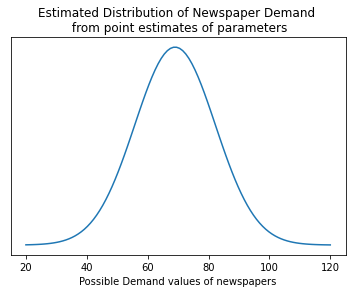

In [22]:
# Gene
x = np.linspace(20, 120, 100)
y = stats.norm(demand_mean, demand_std).pdf(x)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.set_yticks([]);

ax.set_title("Estimated Distribution of Newspaper Demand \n from point estimates of parameters");
ax.set_xlabel("Possible Demand values of newspapers");

## With those two assumptions let's use our formula
In this model the fractile_inventory is the optimal inventory number. We use the objective function to compare to our earlier method

In [23]:
fractile_inventory = demand_seen.mean()+demand_seen.std()*stats.norm.ppf((7-5)/7)
objective_func_value = objective(inventory=fractile_inventory, demands=demand_unseen)

f"Testing inventory choice {np.round(fractile_inventory)} over unseen days yields {objective_func_value} units. Lower is better"

'Testing inventory choice 62.0 over unseen days yields -92.48377690939299 units. Lower is better'

# We did better! 230 -> -92 from objective function
This time we took into account
* The mean
* Uncertainty in our standard deviation
* The cost of overstocking versus understocking

In [24]:
# For the comparison slide
results.loc["Critical_Fractile", "Objective Value"] = objective_func_value

# So what have we done?
<center><img src="img/CriticalFractileWorkflow.png" alt="Drawing" style="height: 500px;"/> </center>

# But how are sure are we?
We only have 5 data points, is our calculated mean and standard deviation the true mean and standard deviation?

## With a small amount of data we can't be sure
Yet with the critical fractile we can only choose one mean and one standard deviation to optimize against

Unfortunately with such little data the estimate of the **true mean** and **true standard deviation** can be challenging

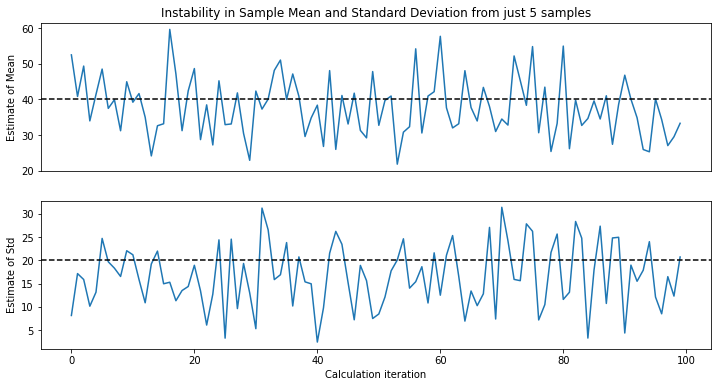

In [25]:
values = np.round(stats.norm(40,  ).rvs(100))
simulations = 100
mean, std = [], []

for _ in range(simulations):
    values = stats.norm(40, 20).rvs(5)
    mean.append(values.mean())
    std.append(values.std())
    
fig, ax = plt.subplots(2,1, figsize = (12, 6))

ax[0].plot(range(simulations), mean)
ax[0].set_xticks([])
ax[0].axhline(40, 0, 1, c="black", linestyle="--")
ax[0].set_ylabel("Estimate of Mean")

ax[1].plot(range(simulations), std)
ax[1].axhline(20, 0, 1, c="black", linestyle="--")
ax[1].set_xlabel("Calculation iteration")
ax[1].set_ylabel("Estimate of Std")
 
ax[0].set_title("Instability in Sample Mean and Standard Deviation from just 5 samples");

# Methodology 3: Let's use Bayesian Statistics
Bayesian statistics treats the data as fixed, but the parameters like mean and standard deviation as unknown. Let's first estimate our parameters.

In [26]:
import pymc3 as pm
import arviz as az
with pm.Model() as newsvendor:
    
    # These are our priors that are set through "experience". Well get back to this
    sd = pm.HalfStudentT("standard_deviation_of_newspaper_demand", sigma=10, nu=20)
    mu = pm.Normal("mean_of_newspaper_demand", demand_seen.mean(), 20)
    demand = pm.TruncatedNormal("demand", mu=mu, sd=sd, lower=0, observed = demand_seen)

    trace = pm.sample(tune=5000, draws=10000, chains=2)
    posterior_predictive = pm.sample_posterior_predictive(trace, progressbar=False)
    inf_data = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean_of_newspaper_demand, standard_deviation_of_newspaper_demand]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 32 seconds.


# Distributions estimates of the Mean and Standard deviation of True demand distribution
In Bayesian statistics one of the outputs are posterior distributions of parameters that describe *possible* distributions of newspapers sold each day  

In our case $N(\mu, \sigma)$ , or "Normal centered at mu with standard deviation sigma"

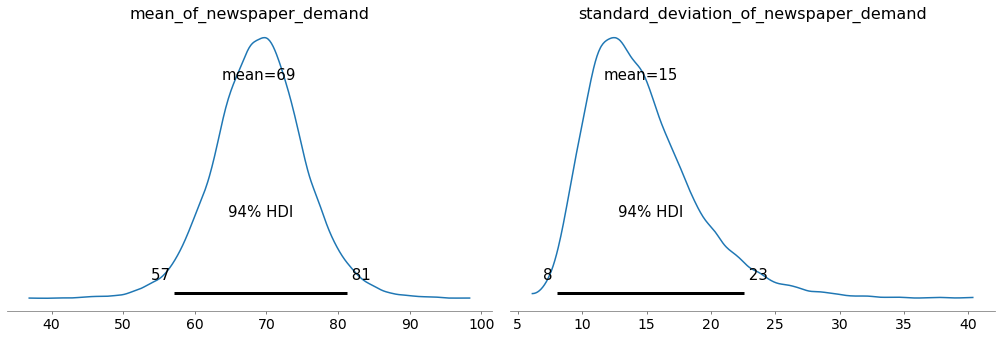

In [27]:
az.plot_posterior(inf_data);

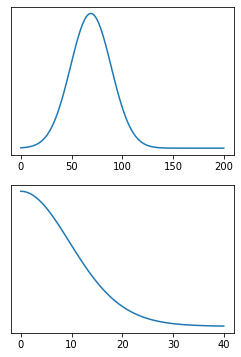

In [28]:
# Create prior distribution plots
# Plot of prior distribution
fig, ax = plt.subplots(2,1, figsize=(4, 6))

# Sigms
x = np.linspace(0, 40, 100)
y = stats.t.pdf(x, df=20, loc=0, scale=10)


ax[1].plot(x,y)
ax[1].set_yticks([]);

# Sigms
x = np.linspace(0, 200, 100)
y = stats.norm(demand_seen.mean(), 20).pdf(x)


ax[0].plot(x,y)
ax[0].set_yticks([]);


# All the distributions of demand estimates
We don't just get one, we get a lot

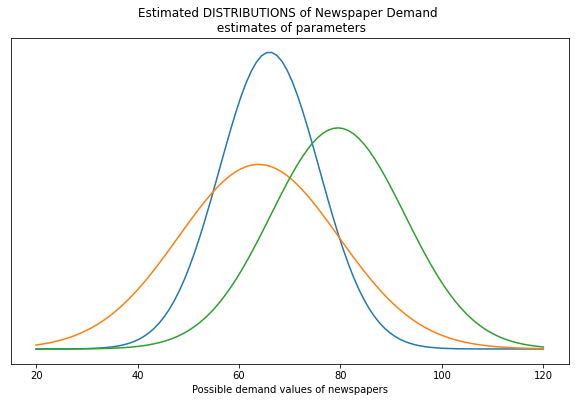

In [29]:
# Get random samples of possible distributions of demand and plot them. Used seed values 0, 10, 15

fig, ax = plt.subplots(figsize=(10, 6))

for seed in [0, 8, 20]:
    np.random.seed(seed)
    mean = np.random.choice(trace["mean_of_newspaper_demand"])
    std = np.random.choice(trace["standard_deviation_of_newspaper_demand"])

    x = np.linspace(20, 120, 100)
    y = stats.norm(mean, std).pdf(x)

    ax.plot(x,y)
    ax.set_yticks([]);


# Set seed back to zero for rest of notebook
np.random.seed(0)
ax.set_title("Estimated DISTRIBUTIONS of Newspaper Demand \n estimates of parameters");
ax.set_xlabel("Possible demand values of newspapers");

## A distribution of estimates of future demand per day (Posterior Predictive)
This means we don't just have single distribution of future demand, but every possible distribution of future demand, from which we can then simulate newspaper demand values

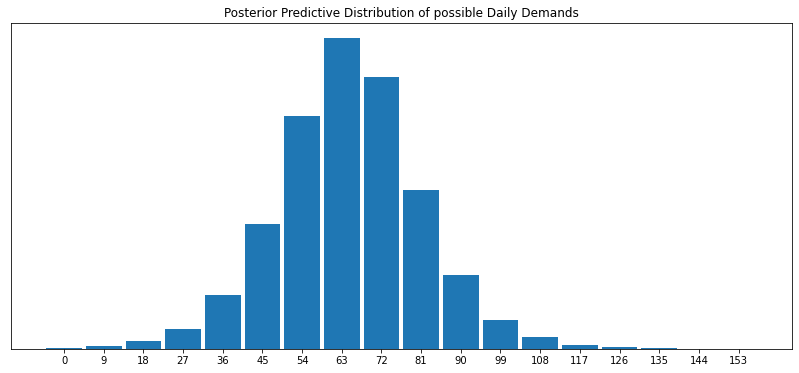

In [30]:
fig, ax = plt.subplots(figsize=(14, 6))
bayesian_demand_estimates = inf_data.posterior_predictive["demand"].values.flatten()

az.plot_dist(bayesian_demand_estimates, kind="hist", ax=ax)
ax.set_title("Posterior Predictive Distribution of possible Daily Demands")
ax.set_yticks([]);

## So many distributions. Let's recap them all

1. Normal Prior Distributions of mean
2. HalfStudentT Prior Distributions of standard deviation
3. Normal Likelihood of Newspaper demand
4. Posterior Distributions of mean 
5. Posterior of standard deviation
6. *Multiple possible distribution of future demand*
7. Posterior Predictive of newspaper demand, drawn from weighted probability of each future

## Now we can optimize over all versions of the future
Let's use our optimizer in conjunction with our objective function to find the optimal *inventory holding choice* given *all possible daily demands*

In [31]:
bayesian_demand_estimates = inf_data.posterior_predictive["demand"].values.flatten()
opt_stoch = optimize.minimize_scalar(objective, bounds=(0, np.inf), args=(bayesian_demand_estimates,))

In [32]:
bayes_opt = opt_stoch.x
f"Optimal inventory from Bayesian demand estimation and optimizer is {np.round(bayes_opt)} newspapers"

'Optimal inventory from Bayesian demand estimation and optimizer is 61.0 newspapers'

In [33]:
objective_func_value = objective(opt_stoch.x, demand_unseen)
f"Testing inventory choice over unseen days yields {objective_func_value} units. Lower is better"

'Testing inventory choice over unseen days yields -127.60140190059406 units. Lower is better'

,Objective Value
Mean,230.000000
Critical_Fractile,-92.483777
Bayesian,-127.601402


# The best so far. Objective function score -127
we're able to maximize the chance that of better outcome by taking into account everything before 

* The central tendency of demand using mean estimates
* Uncertainty in demand with standard deviation estimates
* The cost of overstocking versus understocking

and it also

* incorporates prior business knowledge
* preserves the uncertainty from our smaller data size

By utilizing both we're able to maximize the chance that we get a better outcome!

# So what have we done with Bayes?
<center><img src="img/FullBayesWorkflow.png" alt="Drawing" style="height: 600px;"/> </center>

# Recap of results
By incorporating prior business knowledge and preserving uncertainty we can better plan for future outcomes

In [38]:
results

,Objective Value
Mean,230.000000
Critical_Fractile,-92.483777
Bayesian,-127.601402


# Are there other reasons to use Bayesian methods though?
Why yes

# The real world is much more complex 
Remember newsvendor problem is highly simplified. It assumes
* Non stationary demand distribution which changes over time
* Multiple period inventory
* Variable purchase price
* Variable sales price
* Related factors, like weather (Covariates)

### What if things change?
We'll the critical fractile formula no longer applies, but we can extend the Bayesian Model

#  Distribution flexibility and preservation of aleatoric of uncertainty
Not everything is a symmetric normal and as we saw before 5 data points may not always be not always enough to estimate the true distribution parameterization. Bayesian stats can handle both cases "natively"
<center><img src="img/SkewNormal.png" alt="Drawing" style="height: 500px;"/> </center>

In [ ]:
hide_code_in_slideshow()
fig, ax = plt.subplots(figsize=(10, 6))

x = np.linspace(-20, 300, 100)
y = stats.skewnorm(loc=0, scale=60, a=7).pdf(x)
ax.plot(x,y)
ax.set_yticks([]);
ax.set_xticks([]);
ax.set_title("Non symmetric newspaper demand")
plt.savefig("img/SkewNormal.png")

# Model Extensibility and Flexibility

Anisha learns the real world is messy and demand
* is not fixed but instead varies on weekends, or when its rainy,
* or is increasing over time
* or that she'll always receive
* or that there's 3 sources of demand, working professionals, companies, and students
* or that some newspaper printers are more reliable than others

Bayes can handle this problem!

# Model Extensibliity and Flexibility
Bayesian stats can help you estimate parameters across a range of model architectures 

* Regressions
* Gaussian processes
* Autoregressive model
* State space models


# Ability to share data across groups
Anisha opens up a new newsstand in many different different cities. Information can be shared across cities using hierarchical model

<center><img src="img/hierarchical.png" alt="Drawing" style="height: 300px;"/> </center>

Add reference

# Incorporation of business knowledge in priors

Priors enable data scientists to include human experience in a principled manner

All business decisions take place in a subjective context. Bayesian methods let you incorporate this knowledge into the model in a principled manner, rather than reject it outright

## Wait a second isn't that *gasp* subjective?
Well all statistical methods are subjective.
* In the mean and critical fractile method you must remove "outliers" manually or results can be skewed
* Deciding how far back in history to consider is a human choice
* In critical fractile method you must choose distribution

The choice of model architecture itself is a subjective choice. Sometimes you let dead people like Ronald Fisher make that choice for you but it's subjective nonetheless

There are such a thing as uninformative priors that are purely mathematical but again you're not forced to, but rather given a choice, to use them.

#  My opinion: Greater community adoption of principled workflow

Frequentist math is great, but the workflow are often taught as "plug and chug" in manner where recipes are prescriptive

The Bayesian body of work tends to emphasize thinking from first principles which reduces chance individuals misapply the fundamental math

# So why are methods like critical fractile still around?

* They're still useful! With large datasets good estimations of underlying distributions are possible
    * Not all decisions require a full Bayesian treatment
* Easier to implement. Development time is a business cost to be considered
* Easier to explain to stakeholders. Communication of approach should always be considered
* Historical bias. Still taught in some colleges and in textbooks which haven't incorporated newer methods


# When I suggest you use Bayesian methods

 I have found Bayesian statistics most useful in areas where

* prior business knowledge is important or required
* all the possibilities need to be accounted for, not just the most likely outcome
* flexibiity to create a model of your own architecture

All those are helpful when the impact of the decision is highly consequential

# What did we cover
* Using data to make choices even if there isn't a lot of it
* Working with uncertainty
* Posterior and Posterior Predicted Distributions
* Optimization over posterior predictive distributions
* Cost loss and profit functions

# Bottom Line: Some decisions are just that important
Some decisions are so impactful you need to know all possible outcomes and make good estimations even with little data. Bayesian methods are well suited for these types

# Where to go from here
* Statistical Rethinking
* Bayesian Method for Hackers
* PyMC3 docs
* Regression and other stories